In [2]:
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Recreating the model and loading the trained weights

In [3]:
def l2_distance(tensors):
    x = tensors[0]
    y = tensors[1]
    distance = tf.sqrt(tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True))
    return distance

def conv_block(x, n_filters, size, strides=1):
    x = tf.keras.layers.Conv2D(filters=n_filters,
               kernel_size=size,
               padding='same',
               strides=strides,
               kernel_initializer='he_normal',
               use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def residual_block(x, n_filters):
    skip = x
    x = conv_block(x, n_filters//2, 1)
    x = conv_block(x, n_filters, 3)
    x = tf.keras.layers.add([x, skip])
    return x

def base_model(H=180, W=480):
    input_layer = tf.keras.layers.Input(shape=(H, W, 1))
    x = conv_block(input_layer, 32, 3)
    x = conv_block(x, 64, 3, strides=2)
    x = residual_block(x, 64)
    x = conv_block(x, 128, 3, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = conv_block(x, 256, 3, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    output_layer = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='base_model')
    return model   

In [4]:
base = base_model()

right_image = tf.keras.layers.Input(shape=(180, 480, 1))
left_image = tf.keras.layers.Input(shape=(180, 480, 1))

right_out = base(right_image)
left_out = base(left_image)

y = tf.keras.layers.Lambda(l2_distance )([right_out, left_out])
model = tf.keras.Model(inputs=[right_image, left_image], outputs=y)
model.load_weights('signature_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.


## Defining functions to verify/ match signatures

In [5]:
def get_image(image_path, h=180, w=480):
    '''returns image, pixels scaled [0-1]'''
    img = np.array(tf.keras.preprocessing.image.load_img(image_path, target_size=(h, w), color_mode='grayscale'), dtype=np.float32)[:,:,None]
    img /= 255.
    return img

def validate(image_path_a, image_path_b, actual=None, threshold=0.5):
    '''function to validate a given pair of signatures'''
    img_a = get_image(image_path_a)[None, ...]
    img_b = get_image(image_path_b)[None, ...]
    
    distance = np.squeeze(model.predict([img_a, img_b]))
    distance = np.clip(distance, 0, 1)
    match = 'matched' if distance < threshold else 'not matched'
    confidence = (1 - distance)
    disp = np.concatenate([img_a[0, ..., 0], np.zeros(shape=(180, 10)), img_b[0, ..., 0]], axis=1)
    plt.figure(figsize=(12, 8))
    plt.title(f'Src_image : {actual}\ntarget_image : {match}\nSimilarity_percent : {confidence:.3f}', multialignment='left')
    plt.imshow(disp, cmap='gray')
    return match

## Creating validation data

In [8]:
all_val_images = sorted(glob('/home/spideradmin/Downloads/signature_dataset/SIG-DS-I/*'))
ground_truth = []
signature_pairs = []
for i in range(0, len(all_val_images), 3):
    idx_r = i + np.random.randint(0, 3)
    while True:
        idx_l = i + np.random.randint(0, 3)
        if idx_l != idx_r:
            break
    signature_pairs.append([all_val_images[idx_r], all_val_images[idx_l]])
    ground_truth.append('matched')
    
for i in range(63):
    idx_r = np.random.randint(0, len(all_val_images))
    while True:
        idx_l = np.random.randint(0, len(all_val_images))
        if all_val_images[idx_r].split('/')[-1].split(',')[0] != all_val_images[idx_l].split('/')[-1].split(',')[0]:
            break
    signature_pairs.append([all_val_images[idx_r], all_val_images[idx_l]])
    ground_truth.append('not matched')

IndexError: list index out of range

## Running the validation loop and visualizing predictions
 - Find the confusion matrix after the visualizations

 32%|███▏      | 20/63 [00:03<00:06,  7.14it/s]/home/spideradmin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 89%|████████▉ | 56/63 [00:08<00:00,  8.25it/s]


OSError: cannot identify image file '/home/spideradmin/Downloads/signature_dataset/SIG-DS-I/Thumbs.db'

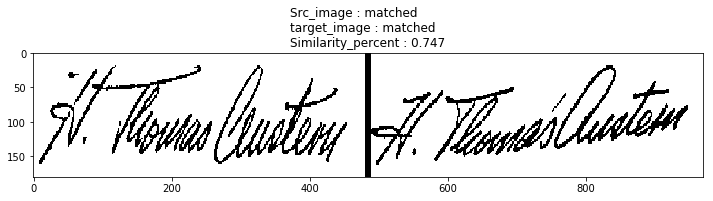

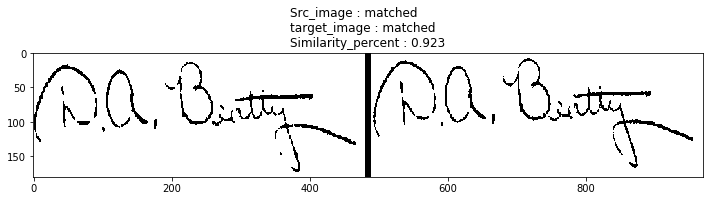

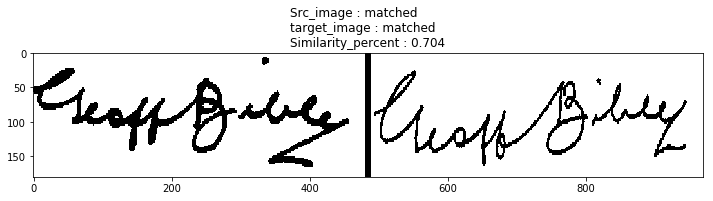

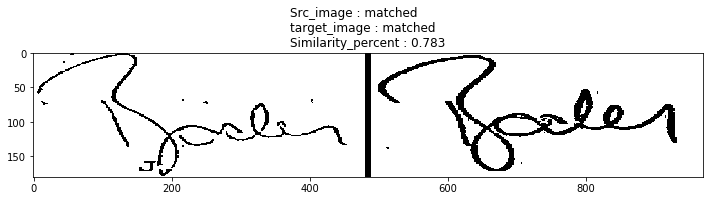

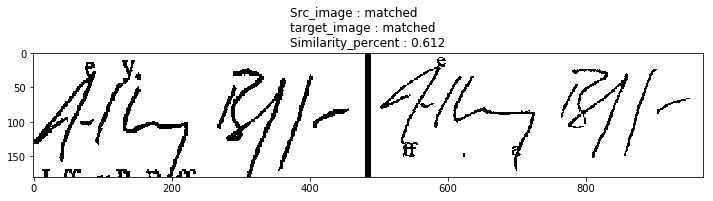

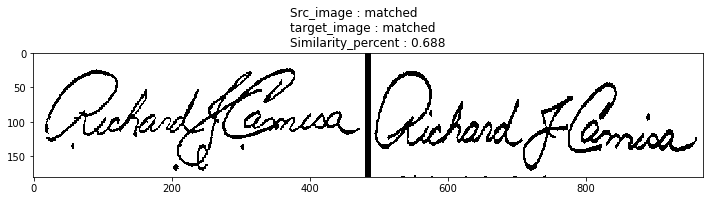

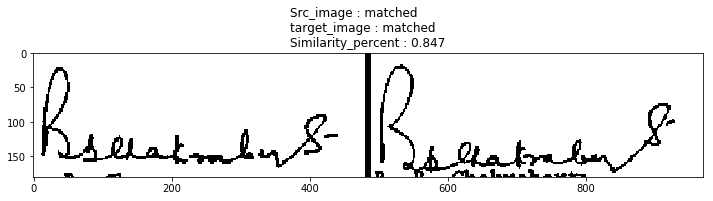

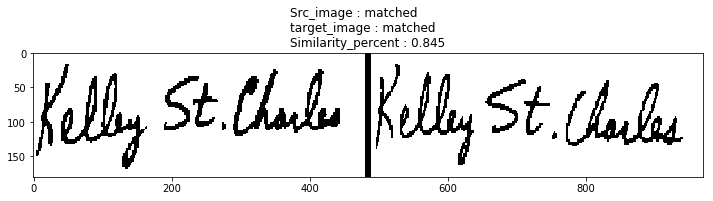

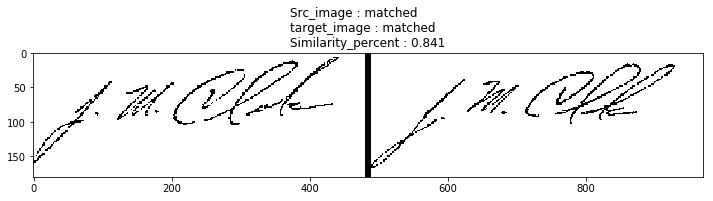

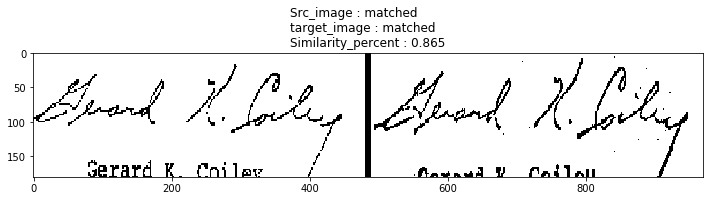

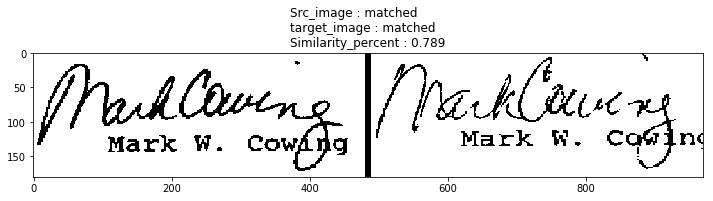

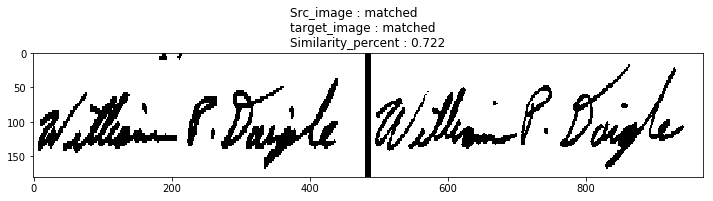

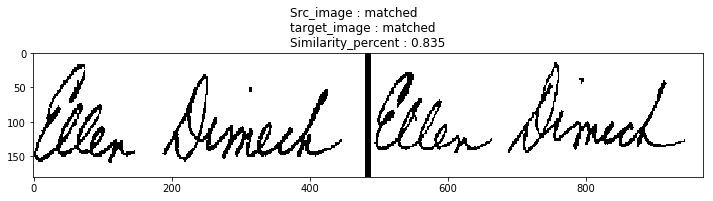

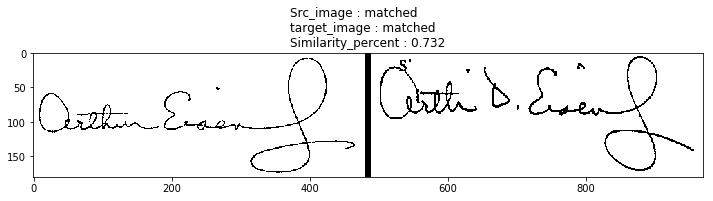

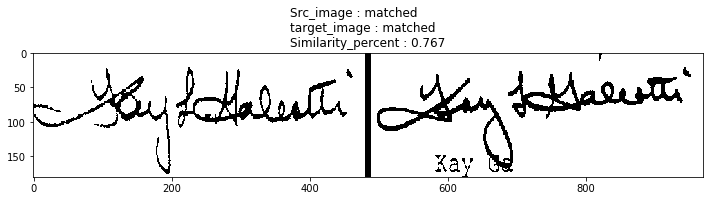

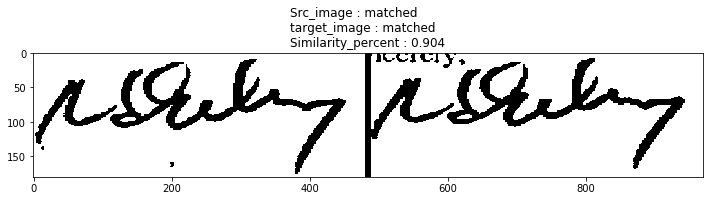

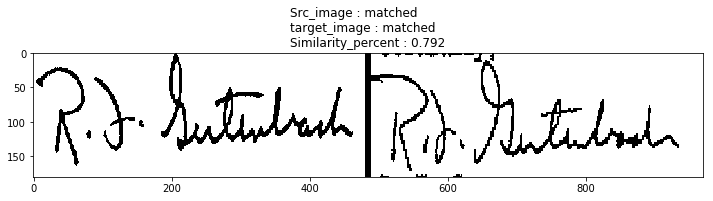

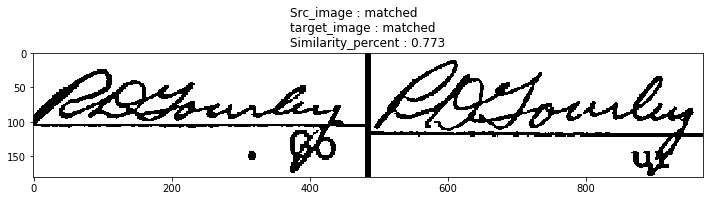

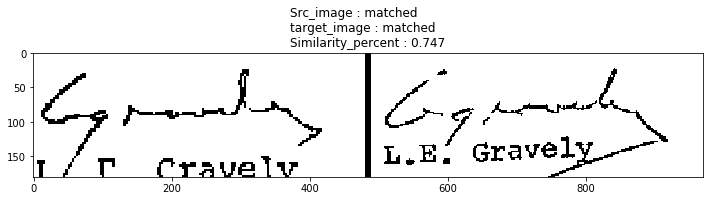

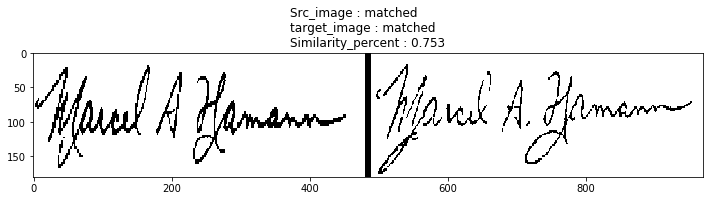

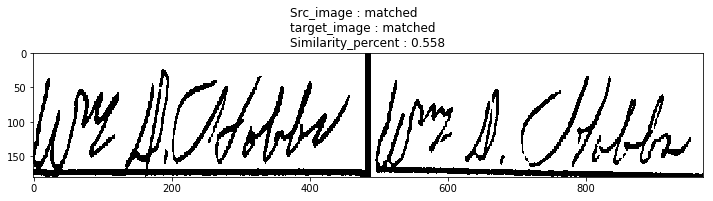

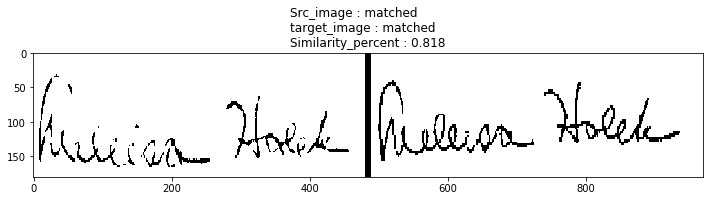

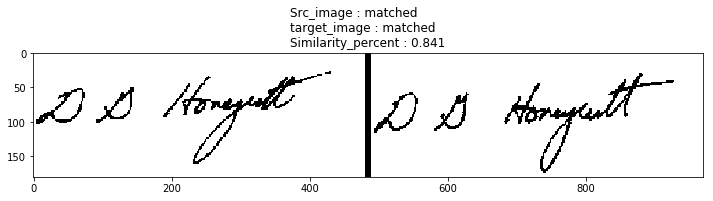

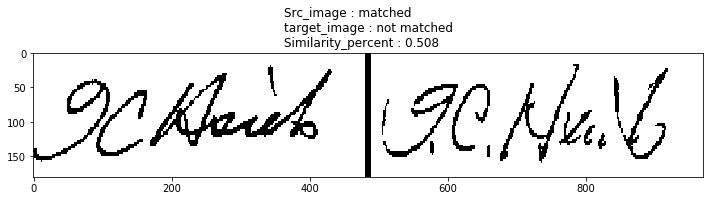

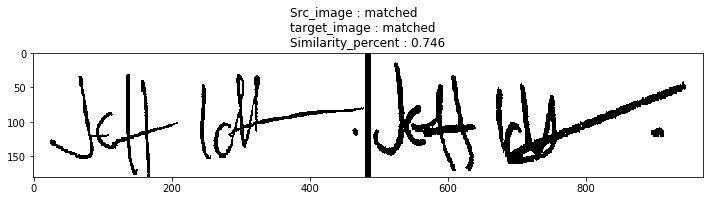

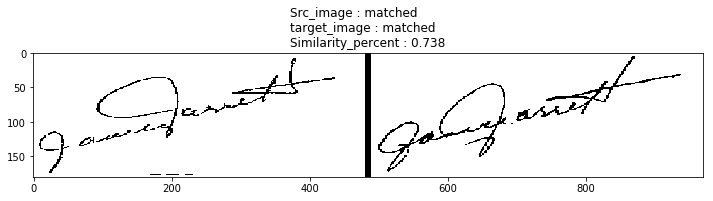

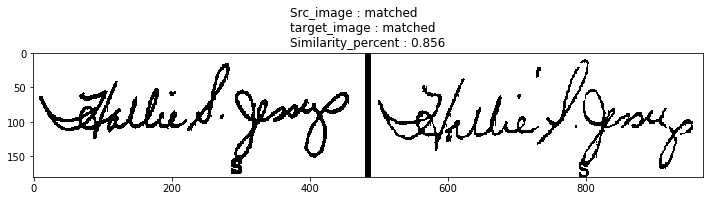

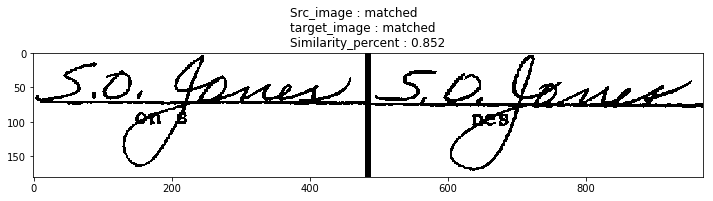

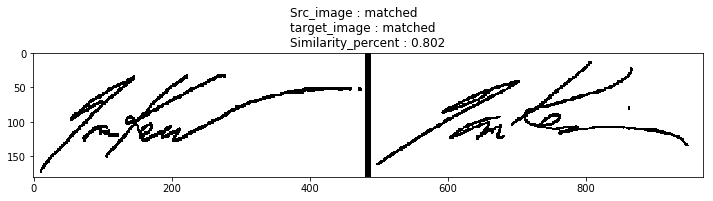

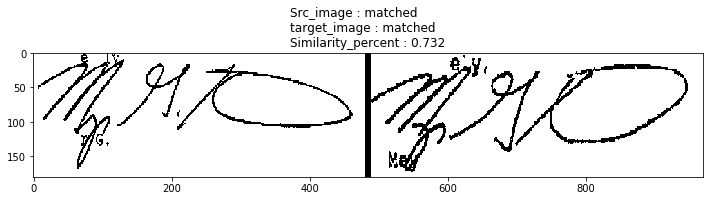

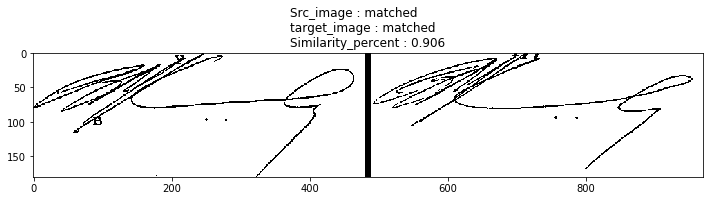

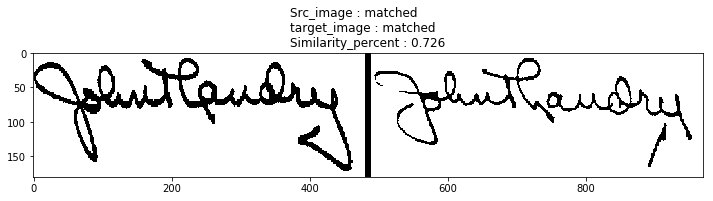

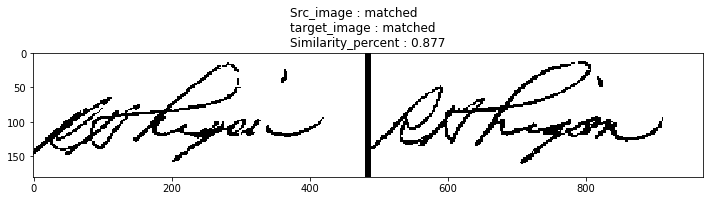

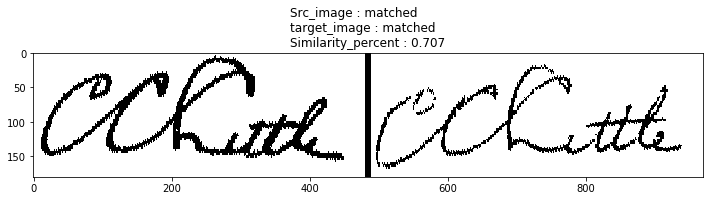

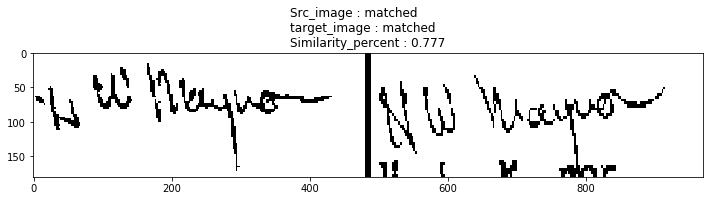

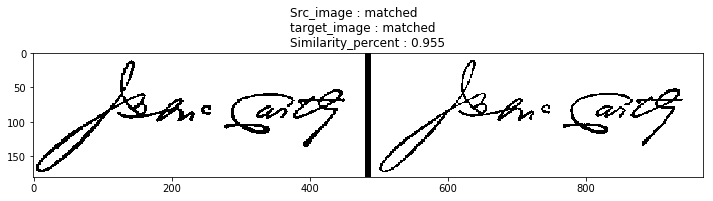

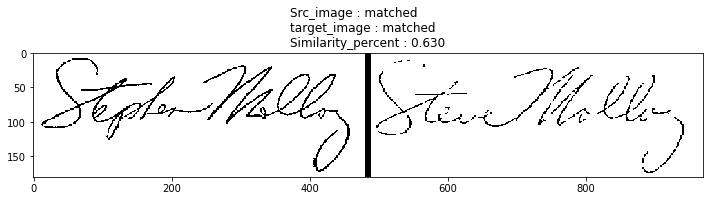

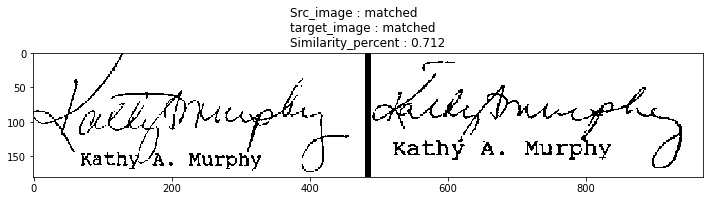

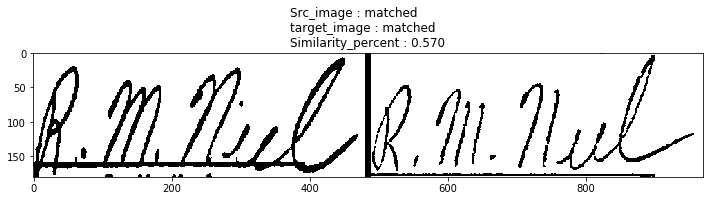

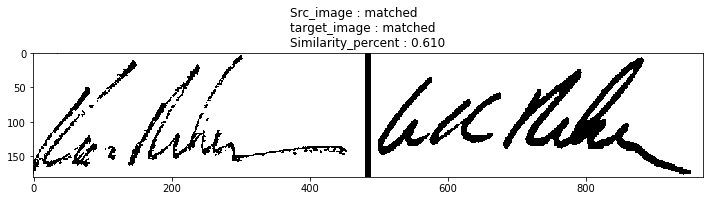

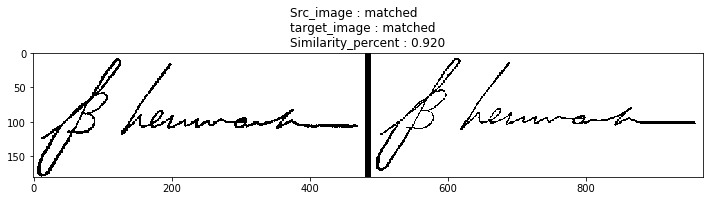

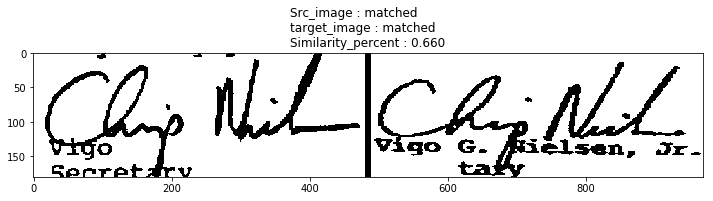

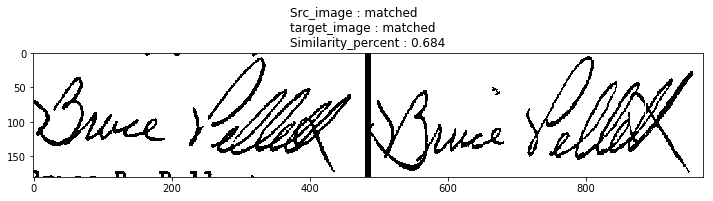

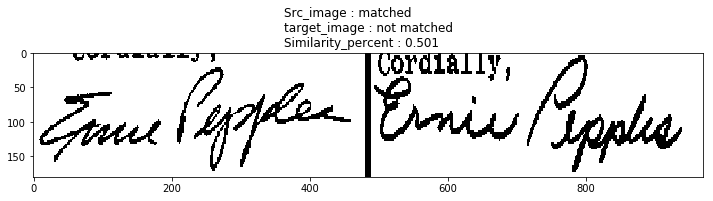

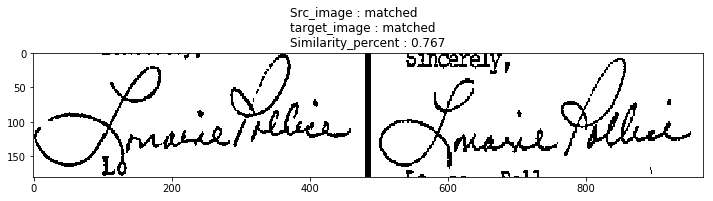

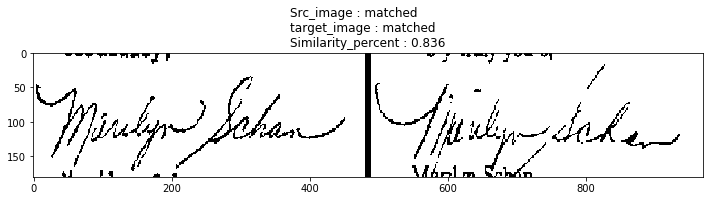

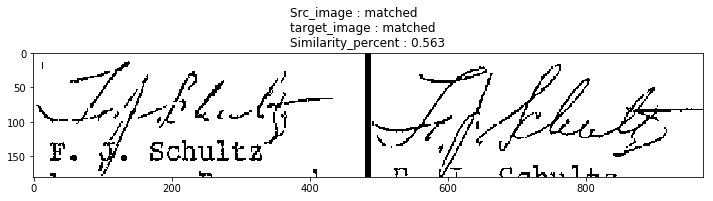

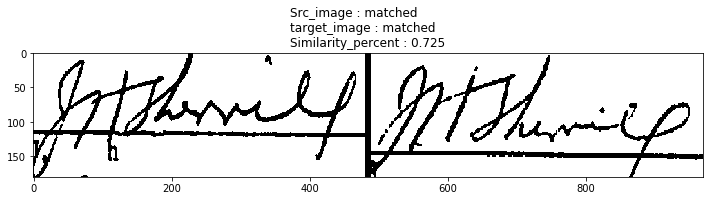

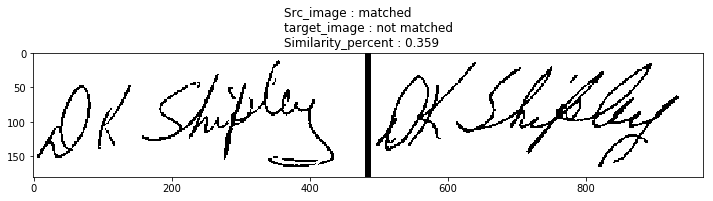

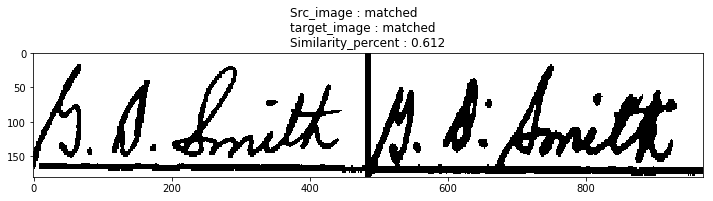

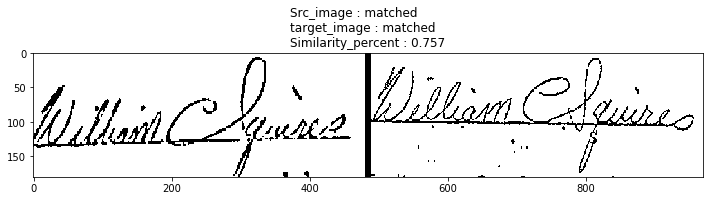

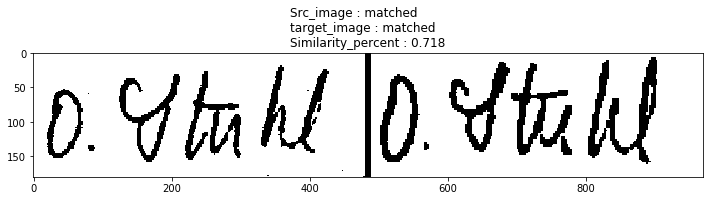

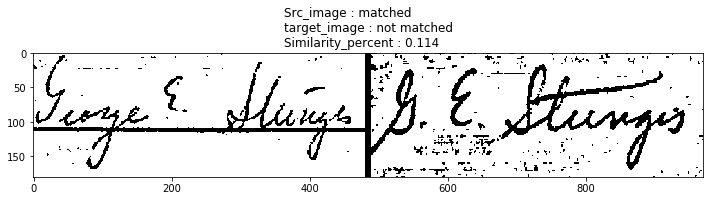

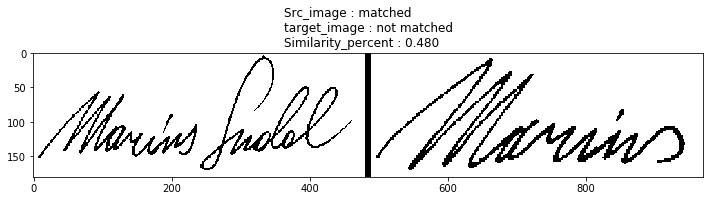

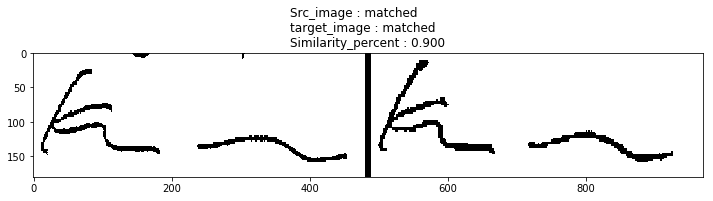

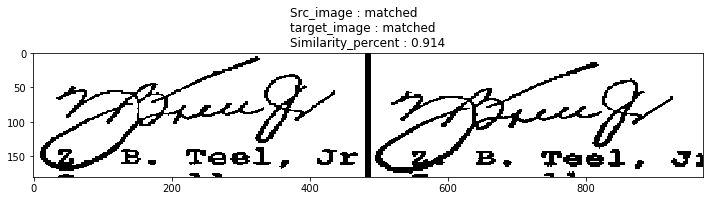

In [9]:
actuals = []
predictions = []
for i in tqdm(range(len(signature_pairs))):
    result = validate(signature_pairs[i][0], signature_pairs[i][1], actual=ground_truth[i], threshold=0.45)
    actuals.append(ground_truth[i])
    predictions.append(result)
print(classification_report(actuals, predictions))
print('Accuracy : ', accuracy_score(actuals, predictions))
cm = np.array(confusion_matrix(actuals, predictions))

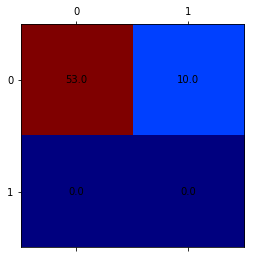

In [16]:
plt.matshow(cm, fignum=1, cmap='jet')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')